In [1]:
!pip install datasets torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [20]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt
from PIL import Image
from datasets import DatasetDict

In [ ]:
fairface = load_dataset("HuggingFaceM4/FairFace", "0.25")

# Split the dataset into training and test sets
train_test_split = fairface["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

train_val_split = train_dataset.train_test_split(test_size=0.2, seed=42)
val_dataset = train_val_split["train"]

# Print dataset sizes to verify
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


# Train dataset size: 69395
# Validation dataset size: 55516
# Test dataset size: 17349

# Train dataset size: 55516
# Validation dataset size: 13879
# Test dataset size: 17349
# Inspect an example record from the training set


Train dataset size: 69395
Validation dataset size: 55516
Test dataset size: 17349


In [27]:
# Function to reduce dataset by percentage
def reduce_dataset(dataset, percentage):
    size = int(len(dataset) * percentage)
    return dataset.select(range(size))


train_dataset = reduce_dataset(train_dataset, 0.01)#0.1
val_dataset = reduce_dataset(val_dataset, 0.01)
test_dataset = reduce_dataset(test_dataset, 0.03)


print(f"Reduced train dataset size: {len(train_dataset)}")
print(f"Reduced validation dataset size: {len(val_dataset)}")
print(f"Reduced test dataset size: {len(test_dataset)}")

Reduced train dataset size: 693
Reduced validation dataset size: 555
Reduced test dataset size: 520


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7FEF150C3DF0>, 'age': 5, 'gender': 1, 'race': 1, 'service_test': False}
Column names: ['image', 'age', 'gender', 'race']


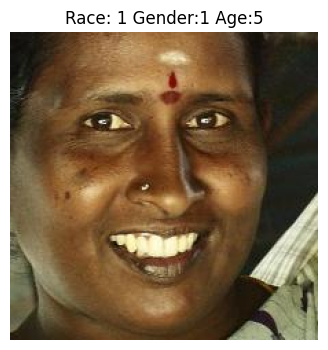

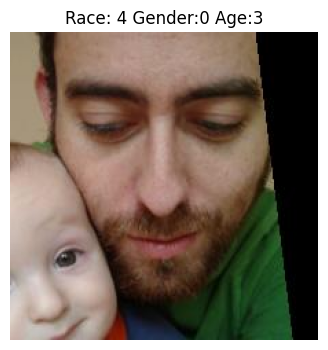

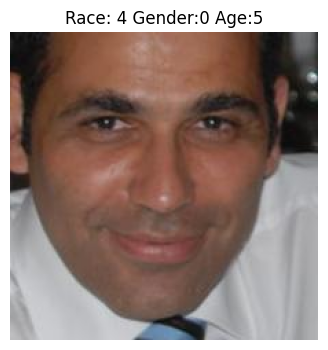

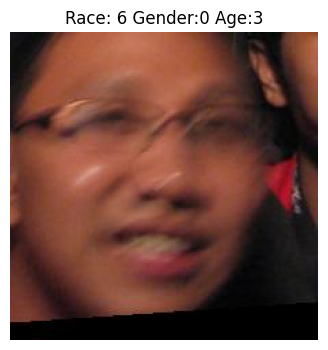

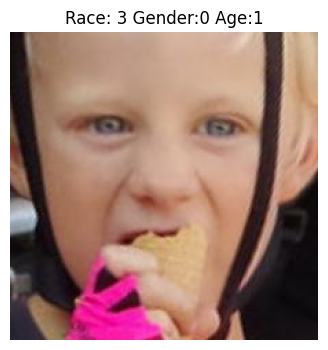

In [28]:
df_train = pd.DataFrame(train_dataset)

# print("Unique races:", df_train['race'].unique())
# print("Unique genders:", df_train['gender'].unique())

# Define gender mapping function
def lable_mapping(dataset):

    gender_map = {0: "Male", 1: "Female"}
    race_map = {0: "East Asian", 1: "Indian", 2: "Black", 3: "White" , 4:"Middle Eastern", 5:"Latino_Hispanic" ,6:"Southeast Asian"}

    mapped_lable = []

    for dslable in dataset:
        dslable["gender"] = gender_map[dslable["gender"]]
        dslable["race"] = race_map[dslable["race"]]
        mapped_lable.append(dslable)

    return mapped_lable

# Apply mapping
mapped_train_dataset = lable_mapping(train_dataset)
mapped_val_dataset = lable_mapping(val_dataset)
mapped_test_dataset = lable_mapping(test_dataset)

# train_dataset = Dataset.from_list(mapped_train_dataset)
# val_dataset = Dataset.from_list(mapped_val_dataset)
# test_dataset = Dataset.from_list(mapped_test_dataset)

print(train_dataset[0])

# Drop the 'service_test' column from the dataset
train_dataset = train_dataset.remove_columns("service_test")
val_dataset = val_dataset.remove_columns("service_test")
test_dataset = test_dataset.remove_columns("service_test")

print("Column names:", train_dataset.column_names)

# Display a few images with labels
for i in range(5):
    image = train_dataset[i]['image']
    label = train_dataset[i]['race']
    gender = train_dataset[i]['gender']
    age = train_dataset[i]['age']
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"Race: {label} Gender:{gender} Age:{age}")
    plt.axis("off")
    plt.show()

In [ ]:
# Function to print original size and shape of images
def print_original_image_size(dataset, num_examples=5):
    for i in range(num_examples):
        raw_image = dataset[i]["image"]

        if isinstance(raw_image, Image.Image):  
            pil_image = raw_image
        else:
            pil_image = Image.fromarray(raw_image)

        print(f"Example {i+1}: Size = {pil_image.size}, Mode = {pil_image.mode}")

# Print original size and shape of images in the train dataset
print("Original image sizes in the train dataset:")
print_original_image_size(train_dataset)

Original image sizes in the train dataset:
Example 1: Size = (224, 224), Mode = RGB
Example 2: Size = (224, 224), Mode = RGB
Example 3: Size = (224, 224), Mode = RGB
Example 4: Size = (224, 224), Mode = RGB
Example 5: Size = (224, 224), Mode = RGB


In [ ]:
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset

class FairFaceDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        image = example["image"]

        if isinstance(image, list):  # If the image is a list, convert to NumPy array
            image = np.array(image, dtype=np.uint8)

        if isinstance(image, np.ndarray):
            if image.ndim == 4:  # Batch of images
                raise ValueError(f"Unexpected batch dimension in dataset image: {image.shape}")
            elif image.ndim == 3:  # Single image
                if image.shape[-1] == 3:  # RGB
                    image = Image.fromarray(image, mode='RGB')
                elif image.shape[-1] == 1:  # Grayscale
                    image = Image.fromarray(image.squeeze(-1), mode='L')
                else:
                    raise ValueError(f"Unexpected image shape: {image.shape}")
            elif image.ndim == 2:  # Grayscale without channels
                image = Image.fromarray(image, mode='L')
            else:
                raise ValueError(f"Unexpected image shape: {image.shape}")
        elif not isinstance(image, Image.Image):
            raise TypeError(f"Unsupported image type: {type(image)}")

        # Apply the transformations if provided
        if self.transform:
            image = self.transform(image)

        # Extract the additional labels
        gender = example["gender"]
        race = example["race"]
        age = example["age"]

        return image, gender, race, age

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import DatasetDict

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define augmentations and normalization for the training dataset
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Wrap datasets
train_dataset = FairFaceDataset(train_dataset, transform=train_transforms)
val_dataset = FairFaceDataset(val_dataset, transform=val_test_transforms)
test_dataset = FairFaceDataset(test_dataset, transform=val_test_transforms)

# Recreate DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# print(f"Raw image type: {type(train_dataset.dataset[0]['image'])}")
# print(f"Raw image shape: {np.array(train_dataset.dataset[0]['image']).shape}")


# image, gender, race, age = train_dataset[0]
# print(f"Image type: {type(image)}")
# print(f"Image shape: {image.shape}")

# # Test one sample from the dataset
# sample = train_dataset[0]
# print(f"Image type: {type(sample[0])}")
# print(f"Image shape: {sample[0].shape}")
# print(f"Gender: {sample[1]}, Race: {sample[2]}, Age: {sample[3]}")
# print(f"Sample type: {type(sample)}")
# if isinstance(sample, tuple):
#     print(f"Image shape: {np.array(sample[0]).shape}")


In [32]:
def inspect_transformed_images(dataloader, num_batches=5):
    for i, (images, genders, races, ages) in enumerate(dataloader):
        print(f"Batch {i+1}:")
        print(f"Image tensor shape: {images.shape}")  # [Batch_size, Channels, Height, Width]
        print(f"Genders: {genders[:5]}")
        print(f"Races: {races[:5]}")
        print(f"Ages: {ages[:5]}")
        if i + 1 == num_batches:
            break

inspect_transformed_images(train_loader)


def inspect_transformed_images(dataloader, num_batches=5):
    for i, (images, genders, races, ages) in enumerate(dataloader):
        print(f"Batch {i+1}:")
        print(f"test_loader Image tensor shape: {images.shape}")  # [Batch_size, Channels, Height, Width]
        print(f"test_loader Genders: {genders[:5]}")
        print(f"test_loader Races: {races[:5]}")
        print(f"test_loader Ages: {ages[:5]}")
        if i + 1 == num_batches:
            break

inspect_transformed_images(test_loader)

Batch 1:
Image tensor shape: torch.Size([32, 3, 224, 224])
Genders: tensor([1, 0, 1, 1, 0])
Races: tensor([3, 3, 0, 0, 3])
Ages: tensor([3, 4, 1, 3, 4])
Batch 2:
Image tensor shape: torch.Size([32, 3, 224, 224])
Genders: tensor([0, 0, 0, 0, 0])
Races: tensor([6, 3, 2, 2, 3])
Ages: tensor([4, 4, 3, 6, 8])
Batch 3:
Image tensor shape: torch.Size([32, 3, 224, 224])
Genders: tensor([1, 0, 0, 1, 1])
Races: tensor([5, 4, 2, 2, 0])
Ages: tensor([2, 4, 4, 2, 1])
Batch 4:
Image tensor shape: torch.Size([32, 3, 224, 224])
Genders: tensor([0, 1, 1, 0, 0])
Races: tensor([0, 3, 5, 3, 0])
Ages: tensor([5, 3, 3, 4, 1])
Batch 5:
Image tensor shape: torch.Size([32, 3, 224, 224])
Genders: tensor([1, 0, 0, 1, 1])
Races: tensor([3, 5, 2, 5, 3])
Ages: tensor([5, 6, 4, 5, 1])
Batch 1:
test_loader Image tensor shape: torch.Size([32, 3, 224, 224])
test_loader Genders: tensor([1, 0, 0, 1, 1])
test_loader Races: tensor([6, 5, 6, 3, 6])
test_loader Ages: tensor([3, 3, 2, 4, 2])
Batch 2:
test_loader Image tensor 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FaceDetectionCNN(nn.Module):
    def __init__(self):
        super(FaceDetectionCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc_shared = nn.Linear(self._get_fc_input_size(), 512)
        self.dropout = nn.Dropout(0.5)

        # Gender (Binary classification)
        self.fc_gender1 = nn.Linear(512, 128)
        self.fc_gender2 = nn.Linear(128, 1)

        # Race (Multiclass classification)
        self.fc_race1 = nn.Linear(512, 128)
        self.fc_race2 = nn.Linear(128, 7)

        # Age (Regression)
        self.fc_age1 = nn.Linear(512, 256)
        self.fc_age2 = nn.Linear(256, 128)
        self.fc_age3 = nn.Linear(128, 1)  # Output for regression

    def _get_fc_input_size(self):
        """Calculates the input size for the fully connected layer."""
        input = torch.randn(1, 3, 224, 224)

        # Pass the dummy input through the convolutional layers
        x = self.pool(F.relu(self.bn1(self.conv1(input))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        # Get the flattened size
        return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        # Shared convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        # Shared fully connected layer
        x = F.relu(self.fc_shared(x))
        x = self.dropout(x)

        # Task-specific outputs
        # Gender
        gender = F.relu(self.fc_gender1(x))
        gender = torch.sigmoid(self.fc_gender2(gender))  # Binary output (probability)

        # Race
        race = F.relu(self.fc_race1(x))
        race = F.softmax(self.fc_race2(race), dim=1)  # Multiclass output (probabilities)

        # Age
        age = F.relu(self.fc_age1(x))
        age = F.relu(self.fc_age2(age))
        age = self.fc_age3(age)

        return gender, race, age

In [34]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

# Hyperparameters
num_epochs = 20
batch_size = 32
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute max_age and min_age
all_ages = []
for _, _, _, ages in train_loader:
    all_ages.extend(ages.cpu().numpy())
max_age = max(all_ages)
min_age = min(all_ages)
print(f"Max Age: {max_age}, Min Age: {min_age}")

class_weights = torch.tensor([1.0, 2.0, 1.5, 0.8, 1.2, 0.9, 1.1])  # Adjust weights based on class frequency
# Model, loss functions, and optimizer
model = FaceDetectionCNN().to(device)
criterion_gender = nn.BCELoss()  # Binary classification
# criterion_race = nn.CrossEntropyLoss()  # Multiclass classification
criterion_race = nn.CrossEntropyLoss(weight=class_weights)
#criterion_race = FocalLoss(alpha=1, gamma=2)

#criterion_age = nn.MSELoss()  # Regression
criterion_age = nn.L1Loss()  # MAE
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Define race mapping
all_races = set()
for _, _, races, _ in train_loader:
    all_races.update(races.cpu().numpy())
race_mapping = {race: i for i, race in enumerate(sorted(all_races))}

# Loss weights
loss_weights = {"gender": 1.0, "race": 1.0, "age":2.0}

#Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_gender_acc, train_race_acc, train_age_rmse = 0, 0, 0

    for images, genders, races, ages in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        # Move data to device
        images, genders, ages = images.to(device), genders.to(device), ages.to(device)
        races = torch.tensor([race_mapping[int(r.item())] for r in races]).to(device)

        # Normalize ages
        ages_normalized = (ages - min_age) / (max_age - min_age)


        # Forward pass
        gender_pred, race_pred, age_pred = model(images)

        # Compute losses
        loss_gender = criterion_gender(gender_pred.squeeze(), genders.float())
        loss_race = criterion_race(race_pred, races)
        loss_age = criterion_age(age_pred.squeeze(), ages_normalized.float())

        # Combine losses
        loss = (
            loss_weights["gender"] * loss_gender +
            loss_weights["race"] * loss_race +
            loss_weights["age"] * loss_age
        )


        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        train_loss += loss.item()
        train_gender_acc += (torch.round(gender_pred.squeeze()) == genders).float().mean().item()
        train_race_acc += (race_pred.argmax(dim=1) == races).float().mean().item()

        # Denormalize ages for RMSE
        age_pred_denorm = age_pred.squeeze() * (max_age - min_age) + min_age
        train_age_rmse += ((age_pred_denorm - ages) ** 2).mean().sqrt().item()

    # Average metrics
    num_batches = len(train_loader)
    train_loss /= num_batches
    train_gender_acc /= num_batches
    train_race_acc /= num_batches
    train_age_rmse /= num_batches

    print(f"Epoch {epoch + 1}: Loss={train_loss:.4f}, Gender Acc={train_gender_acc:.4f}, "
          f"Race Acc={train_race_acc:.4f}, Age RMSE={train_age_rmse:.4f}")

Max Age: 8, Min Age: 0


Epoch 1/20: 100%|██████████| 22/22 [00:30<00:00,  1.40s/it]


Epoch 1: Loss=3.1511, Gender Acc=0.5494, Race Acc=0.1371, Age RMSE=2.4034


Epoch 2/20: 100%|██████████| 22/22 [00:30<00:00,  1.39s/it]


Epoch 2: Loss=3.0379, Gender Acc=0.5687, Race Acc=0.1351, Age RMSE=2.0471


Epoch 3/20: 100%|██████████| 22/22 [00:30<00:00,  1.41s/it]


Epoch 3: Loss=2.9972, Gender Acc=0.5779, Race Acc=0.1364, Age RMSE=1.9571


Epoch 4/20: 100%|██████████| 22/22 [00:31<00:00,  1.41s/it]


Epoch 4: Loss=2.9528, Gender Acc=0.5956, Race Acc=0.1415, Age RMSE=1.8162


Epoch 5/20: 100%|██████████| 22/22 [00:31<00:00,  1.44s/it]


Epoch 5: Loss=2.9297, Gender Acc=0.6098, Race Acc=0.1399, Age RMSE=1.7677


Epoch 6/20: 100%|██████████| 22/22 [00:31<00:00,  1.42s/it]


Epoch 6: Loss=2.9286, Gender Acc=0.6205, Race Acc=0.1499, Age RMSE=1.7761


Epoch 7/20: 100%|██████████| 22/22 [00:31<00:00,  1.44s/it]


Epoch 7: Loss=2.9203, Gender Acc=0.6040, Race Acc=0.1527, Age RMSE=1.7610


Epoch 8/20: 100%|██████████| 22/22 [00:31<00:00,  1.42s/it]


Epoch 8: Loss=2.9071, Gender Acc=0.6126, Race Acc=0.1507, Age RMSE=1.7679


Epoch 9/20: 100%|██████████| 22/22 [00:30<00:00,  1.40s/it]


Epoch 9: Loss=2.8867, Gender Acc=0.6462, Race Acc=0.1443, Age RMSE=1.6869


Epoch 10/20: 100%|██████████| 22/22 [00:31<00:00,  1.42s/it]


Epoch 10: Loss=2.9002, Gender Acc=0.6391, Race Acc=0.1450, Age RMSE=1.6997


Epoch 11/20: 100%|██████████| 22/22 [00:31<00:00,  1.44s/it]


Epoch 11: Loss=2.8794, Gender Acc=0.6340, Race Acc=0.1556, Age RMSE=1.6889


Epoch 12/20: 100%|██████████| 22/22 [00:31<00:00,  1.42s/it]


Epoch 12: Loss=2.8667, Gender Acc=0.6190, Race Acc=0.1529, Age RMSE=1.6533


Epoch 13/20: 100%|██████████| 22/22 [00:31<00:00,  1.42s/it]


Epoch 13: Loss=2.8410, Gender Acc=0.6519, Race Acc=0.1670, Age RMSE=1.6162


Epoch 14/20: 100%|██████████| 22/22 [00:31<00:00,  1.45s/it]


Epoch 14: Loss=2.8557, Gender Acc=0.6545, Race Acc=0.1649, Age RMSE=1.6935


Epoch 15/20: 100%|██████████| 22/22 [00:31<00:00,  1.45s/it]


Epoch 15: Loss=2.8588, Gender Acc=0.6412, Race Acc=0.1755, Age RMSE=1.7045


Epoch 16/20: 100%|██████████| 22/22 [00:31<00:00,  1.43s/it]


Epoch 16: Loss=2.8439, Gender Acc=0.6646, Race Acc=0.1897, Age RMSE=1.6568


Epoch 17/20: 100%|██████████| 22/22 [00:31<00:00,  1.43s/it]


Epoch 17: Loss=2.8412, Gender Acc=0.6353, Race Acc=0.2169, Age RMSE=1.6514


Epoch 18/20: 100%|██████████| 22/22 [00:32<00:00,  1.48s/it]


Epoch 18: Loss=2.7976, Gender Acc=0.6732, Race Acc=0.1826, Age RMSE=1.5730


Epoch 19/20: 100%|██████████| 22/22 [00:32<00:00,  1.46s/it]


Epoch 19: Loss=2.8077, Gender Acc=0.6538, Race Acc=0.2060, Age RMSE=1.6251


Epoch 20/20: 100%|██████████| 22/22 [00:31<00:00,  1.42s/it]

Epoch 20: Loss=2.7899, Gender Acc=0.6602, Race Acc=0.1947, Age RMSE=1.6252


In [35]:
import matplotlib.pyplot as plt

race_map = {0: "East Asian", 1: "Indian", 2: "Black", 3: "White" , 4:"Middle Eastern", 5:"Latino_Hispanic" ,6:"Southeast Asian"}
idx_to_race = {v: k for k, v in race_mapping.items()}  # Reverse mapping

def visualize_predictions(images, gender_preds, race_preds, age_preds, genders, races, ages, race_map):
    # Convert tensors to numpy for visualization
    images = images.permute(0, 2, 3, 1).cpu().numpy()  # Convert to HWC format for visualization
    gender_preds = torch.round(gender_preds.squeeze()).cpu().numpy()
    race_preds = race_preds.argmax(dim=1).cpu().numpy()
    age_preds = age_preds.squeeze().cpu().numpy()
    genders = genders.cpu().numpy()
    races = races.cpu().numpy()
    ages = ages.cpu().numpy()

    # Gender mapping: 0 -> Male, 1 -> Female
    gender_map = {0: "Male", 1: "Female"}
    gender_preds_labels = [gender_map[int(g)] for g in gender_preds]
    genders_labels = [gender_map[int(g)] for g in genders]

    # Race mapping: Convert numerical to string
    race_preds_labels = [race_map.get(r, "Unknown") for r in race_preds]
    races_labels = [race_map.get(r, "Unknown") for r in races]

  # Plot the images row by row
    num_images = min(12, len(images))  # Show up to 8 images
    num_cols = 4  # Number of columns per row
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

    # Flatten axes to simplify indexing
    axes = axes.flatten()

    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i])
        ax.axis("off")
        ax.set_title(
            f"True: Gender={genders_labels[i]}, Race={races_labels[i]}, Age={ages[i]:.1f}\n"
            f"Pred: Gender={gender_preds_labels[i]}, Race={race_preds_labels[i]}, Age={age_preds[i]:.1f}",
            fontsize=8,
        )

    # Turn off any remaining axes
    for i in range(num_images, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

Predicted ages (denormalized): [2. 3. 2. 3. 2.]
Actual ages: [3 3 2 4 2]
Predicted ages (denormalized): [2. 2. 3. 3. 2.]
Actual ages: [4 7 1 3 2]
Predicted ages (denormalized): [3. 3. 3. 2. 3.]
Actual ages: [6 1 1 3 4]
Predicted ages (denormalized): [2. 3. 2. 2. 2.]
Actual ages: [3 4 5 7 1]
Predicted ages (denormalized): [2. 3. 2. 3. 2.]
Actual ages: [5 2 2 4 2]
Predicted ages (denormalized): [3. 2. 3. 2. 2.]
Actual ages: [5 4 4 3 4]
Predicted ages (denormalized): [3. 2. 2. 2. 3.]
Actual ages: [8 7 1 5 5]
Predicted ages (denormalized): [3. 3. 3. 2. 3.]
Actual ages: [1 5 4 6 1]
Predicted ages (denormalized): [2. 2. 3. 2. 2.]
Actual ages: [3 3 4 1 4]
Predicted ages (denormalized): [3. 2. 3. 3. 3.]
Actual ages: [3 4 5 5 6]
Predicted ages (denormalized): [3. 3. 2. 2. 3.]
Actual ages: [4 7 3 5 6]
Predicted ages (denormalized): [2. 2. 2. 3. 2.]
Actual ages: [3 3 6 3 3]
Predicted ages (denormalized): [3. 2. 3. 3. 2.]
Actual ages: [3 1 4 4 5]
Predicted ages (denormalized): [2. 2. 2. 2. 2.]
Act

Predicted ages (denormalized): [2. 2. 3. 2. 3.]
Actual ages: [6 1 8 1 3]
Predicted ages (denormalized): [2. 3. 3. 3. 3.]
Actual ages: [2 1 4 3 4]
Test: Loss=2.8109, Gender Acc=0.6912, Race Acc=0.2040, Age RMSE=1.8469


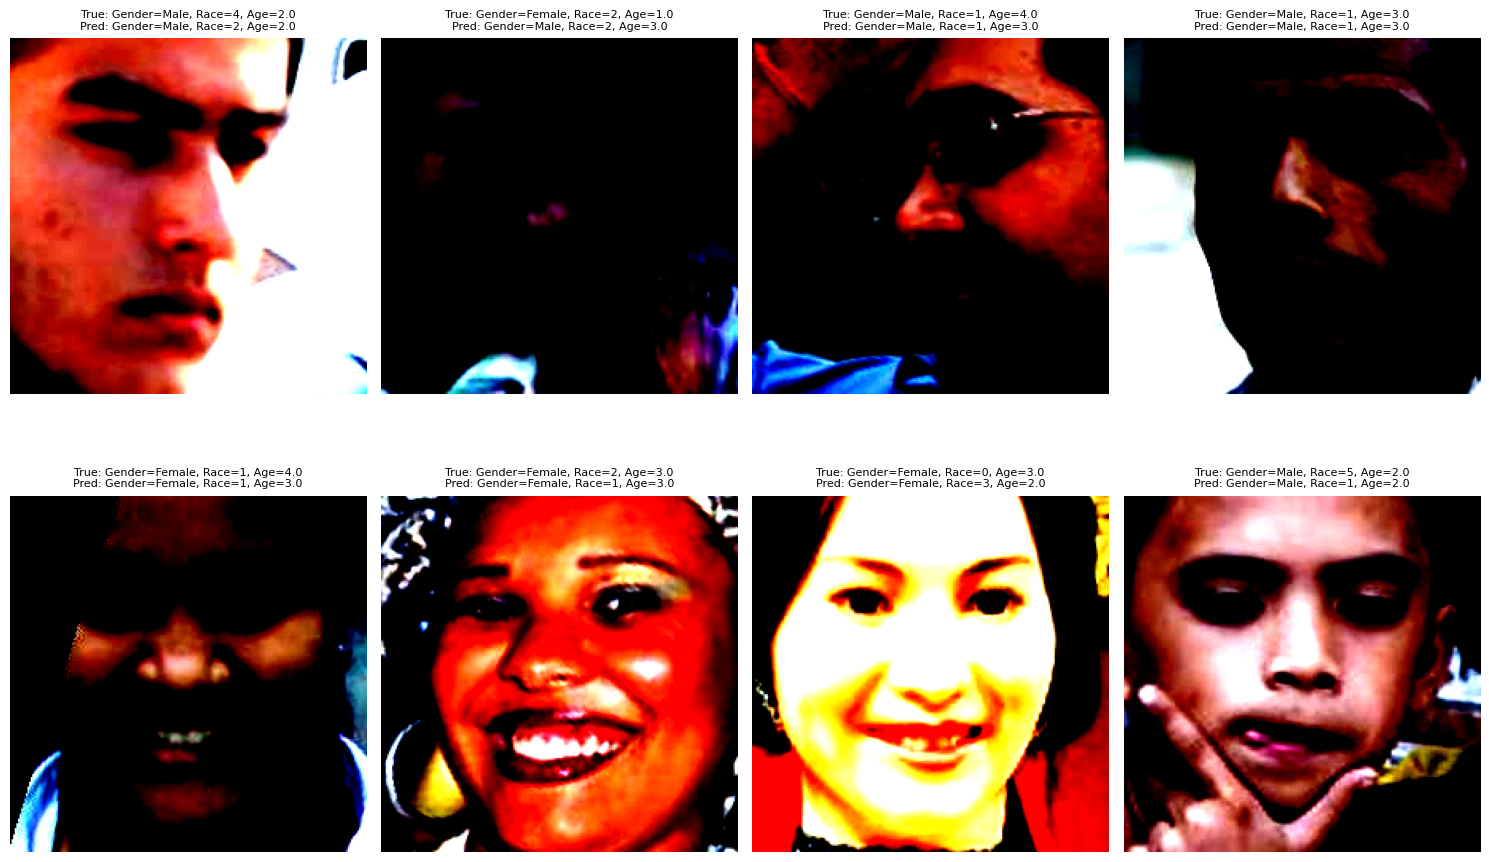

In [ ]:
# Testing Loop
model.eval() 
test_loss = 0.0
test_gender_acc, test_race_acc, test_age_rmse = 0, 0, 0

race_map = {0: "East Asian", 1: "Indian", 2: "Black", 3: "White" , 4:"Middle Eastern", 5:"Latino_Hispanic" ,6:"Southeast Asian"}
idx_to_race = {v: k for k, v in race_mapping.items()}  # Reverse mapping

with torch.no_grad():  # Disable gradient calculation for testing
    for images, genders, races, ages in test_loader:
        images = images.to(device)
        genders = genders.to(device)
        #races = races.to(device)  # Assuming numerical labels in races
        races = torch.tensor([race_mapping[r.item()] for r in races]).to(device)
        ages = ages.to(device)

        # Normalize ages
        ages_normalized = (ages - min_age) / (max_age - min_age)

        # Forward pass
        gender_pred, race_pred, age_pred = model(images)


        # Compute losses
        loss_gender = criterion_gender(gender_pred.squeeze(), genders.float())
        loss_race = criterion_race(race_pred, races)  # Use races here
        loss_age = criterion_age(age_pred.squeeze(), ages_normalized.float())  # Match scale

        # Combine losses
        # loss = loss_gender + loss_race + loss_age
        # test_loss += loss.item()
        # Combine losses
        loss = (
            loss_weights["gender"] * loss_gender +
            loss_weights["race"] * loss_race +
            loss_weights["age"] * loss_age
        )
        test_loss += loss.item()


        # Calculate metrics
        test_gender_acc += (torch.round(gender_pred.squeeze()) == genders).float().mean().item()
        test_race_acc += (race_pred.argmax(dim=1) == races).float().mean().item()
        # test_age_rmse += torch.sqrt(criterion_age(age_pred.squeeze(), ages.float())).item()

         # Denormalize predicted ages
        age_pred_denorm = age_pred.squeeze() * (max_age - min_age) + min_age
        age_pred_rounded = torch.round(age_pred_denorm)
        test_age_rmse += ((age_pred_rounded - ages) ** 2).mean().sqrt().item()

        # Debugging outputs
        print(f"Predicted ages (denormalized): {age_pred_rounded.cpu().numpy()[:5]}")
        print(f"Actual ages: {ages.cpu().numpy()[:5]}")

    # Average metrics
    num_batches = len(test_loader)
    test_loss /= num_batches
    test_gender_acc /= num_batches
    test_race_acc /= num_batches
    test_age_rmse /= num_batches

    print(f"Test: Loss={test_loss:.4f}, Gender Acc={test_gender_acc:.4f}, Race Acc={test_race_acc:.4f}, Age RMSE={test_age_rmse:.4f}")

     # Visualize the predictions from testing set
    visualize_predictions(
        images, gender_pred, race_pred, age_pred_rounded, genders, races, ages, idx_to_race
    )

In [37]:
# Validation Loop
model.eval()
val_loss = 0.0
val_gender_acc, val_race_acc, val_age_rmse = 0, 0, 0

race_map = {0: "East Asian", 1: "Indian", 2: "Black", 3: "White" , 4:"Middle Eastern", 5:"Latino_Hispanic" ,6:"Southeast Asian"}
idx_to_race = {v: k for k, v in race_mapping.items()}  # Reverse mapping

with torch.no_grad():
    for images, genders, races, ages in val_loader:
        images = images.to(device)
        genders = genders.to(device)
        #races = torch.tensor([race_mapping[r.item()] for r in races]).to(device)
        races = races.to(device) # Change this line
        ages = ages.to(device)

        # Normalize ages
        ages_normalized = (ages - min_age) / (max_age - min_age)

        # Forward pass
        gender_pred, race_pred, age_pred = model(images)

        # Compute losses
        loss_gender = criterion_gender(gender_pred.squeeze(), genders.float())
        loss_race = criterion_race(race_pred, races)  # Use races here
        loss_age = criterion_age(age_pred.squeeze(), ages_normalized.float())

        # Combine losses
        loss = (
            loss_weights["gender"] * loss_gender +
            loss_weights["race"] * loss_race +
            loss_weights["age"] * loss_age
        )
        val_loss += loss.item()

        # Track metrics
        val_gender_acc += (torch.round(gender_pred.squeeze()) == genders).float().mean().item()
        val_race_acc += (race_pred.argmax(dim=1) == races).float().mean().item()

        # Denormalize and round predicted ages
        age_pred_denorm = age_pred * (max_age - min_age) + min_age
        age_pred_rounded = torch.round(age_pred_denorm)
        val_age_rmse += ((age_pred_rounded - ages) ** 2).mean().sqrt().item()

    # Average metrics
    num_batches = len(val_loader)
    val_loss /= num_batches
    val_gender_acc /= num_batches
    val_race_acc /= num_batches
    val_age_rmse /= num_batches

    print(f"Validation: Loss={val_loss:.4f}, Gender Acc={val_gender_acc:.4f}, "
          f"Race Acc={val_race_acc:.4f}, Age RMSE={val_age_rmse:.4f}")

Validation: Loss=2.8798, Gender Acc=0.6566, Race Acc=0.1578, Age RMSE=1.9383


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Performance Metrics
--------------------------------------------------
Metric                   Value          
--------------------------------------------------
Gender F1-Score          0.6804
Gender Precision         0.6830
Gender Recall            0.6827
Race F1-Score            0.1142
Race Precision           0.1522
Race Recall              0.1904
Age MSE                  13.1159
--------------------------------------------------


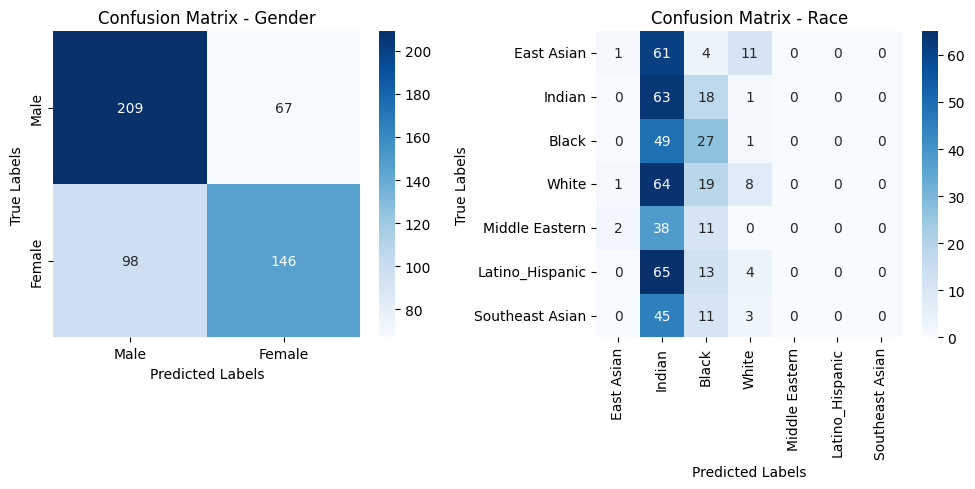


Classification Report for Gender:
              precision    recall  f1-score   support

        Male       0.68      0.76      0.72       276
      Female       0.69      0.60      0.64       244

    accuracy                           0.68       520
   macro avg       0.68      0.68      0.68       520
weighted avg       0.68      0.68      0.68       520


Classification Report for Race:
                 precision    recall  f1-score   support

     East Asian       0.25      0.01      0.02        77
         Indian       0.16      0.77      0.27        82
          Black       0.26      0.35      0.30        77
          White       0.29      0.09      0.13        92
 Middle Eastern       0.00      0.00      0.00        51
Latino_Hispanic       0.00      0.00      0.00        82
Southeast Asian       0.00      0.00      0.00        59

       accuracy                           0.19       520
      macro avg       0.14      0.17      0.10       520
   weighted avg       0.15      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def calculate_metrics(true_genders, pred_genders, true_races, pred_races, true_ages, pred_ages):
    # Confusion Matrices
    gender_cm = confusion_matrix(true_genders, pred_genders)
    race_cm = confusion_matrix(true_races, pred_races)

    # F1, Precision, Recall for Gender
    gender_f1 = f1_score(true_genders, pred_genders, average="weighted")
    gender_precision = precision_score(true_genders, pred_genders, average="weighted")
    gender_recall = recall_score(true_genders, pred_genders, average="weighted")

    # F1, Precision, Recall for Race
    race_f1 = f1_score(true_races, pred_races, average="weighted")
    race_precision = precision_score(true_races, pred_races, average="weighted")
    race_recall = recall_score(true_races, pred_races, average="weighted")

    # Age Metrics
    age_mse = mean_squared_error(true_ages, pred_ages)
    age_r2 = r2_score(true_ages, pred_ages)

    # Display Metrics
    print("Performance Metrics")
    print("-" * 50)
    print(f"{'Metric':<25}{'Value':<15}")
    print("-" * 50)
    print(f"{'Gender F1-Score':<25}{gender_f1:.4f}")
    print(f"{'Gender Precision':<25}{gender_precision:.4f}")
    print(f"{'Gender Recall':<25}{gender_recall:.4f}")
    print(f"{'Race F1-Score':<25}{race_f1:.4f}")
    print(f"{'Race Precision':<25}{race_precision:.4f}")
    print(f"{'Race Recall':<25}{race_recall:.4f}")
    print(f"{'Age MSE':<25}{age_mse:.4f}")
    print("-" * 50)

    # Gender confusion matrix
    gender_cm = confusion_matrix(true_genders, pred_genders)
    gender_labels = ["Male", "Female"]

    # Race confusion matrix
    race_cm = confusion_matrix(true_races, pred_races)
    race_classes = ["East Asian", "Indian", "Black", "White", "Middle Eastern", "Latino_Hispanic", "Southeast Asian"]

    # Plot Gender Confusion Matrix
    plt.figure(figsize=(10, 5))

    # Gender Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(gender_cm, annot=True, fmt="d", cmap="Blues", xticklabels=gender_labels, yticklabels=gender_labels)
    plt.title("Confusion Matrix - Gender")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

    # Race Matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(race_cm, annot=True, fmt="d", cmap="Blues", xticklabels=race_classes, yticklabels=race_classes)
    plt.title("Confusion Matrix - Race")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

    plt.tight_layout()
    plt.show()


    # Classification Reports
    print("\nClassification Report for Gender:")
    print(classification_report(true_genders, pred_genders, target_names=["Male", "Female"]))

    race_classes = ["East Asian", "Indian", "Black", "White", "Middle Eastern", "Latino_Hispanic", "Southeast Asian"]
    print("\nClassification Report for Race:")
    print(classification_report(true_races, pred_races, target_names=race_classes))


true_genders = []
pred_genders = []
true_races = []
pred_races = []
true_ages = []
pred_ages = []

# Get predictions for the test set
with torch.no_grad():
    for images, genders, races, ages in test_loader:
        images = images.to(device)
        genders = genders.to(device)
        races = races.to(device)
        ages = ages.to(device)

        # Forward pass
        gender_pred, race_pred, age_pred = model(images)

        # Store true and predicted values
        true_genders.extend(genders.cpu().numpy())
        pred_genders.extend(torch.round(gender_pred.squeeze()).cpu().numpy())
        true_races.extend(races.cpu().numpy())
        pred_races.extend(race_pred.argmax(dim=1).cpu().numpy())
        true_ages.extend(ages.cpu().numpy())
        pred_ages.extend(age_pred.squeeze().cpu().numpy())

# Assuming true_genders, pred_genders, true_races, pred_races, true_ages, pred_ages are available
calculate_metrics(true_genders, pred_genders, true_races, pred_races, true_ages, pred_ages)